In [1]:
# Phase 2: Data Transformation & Clustering
!pip install seaborn

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

#load clean data
df = pd.read_csv("../data/online_retail_clean.csv", encoding="ISO-8859-1")

# If the column names are different, unify them.
df.columns = [c.strip().lower().replace(" ", "") for c in df.columns]

#transactionno, customerno, date, quantity, price, totalprice
if "totalprice" not in df.columns and {"quantity","price"}.issubset(df.columns):
    df["totalprice"] = pd.to_numeric(df["quantity"], errors="coerce") * pd.to_numeric(df["price"], errors="coerce")

#convert
df["date"] = pd.to_datetime(df["date"], errors="coerce")

#RFM
snapshot_date = df["date"].max() + timedelta(days=1)
rfm = (
    df.groupby("customerno")
      .agg(
          recency=("date",        lambda x: (snapshot_date - x.max()).days),
          frequency=("transactionno","nunique"),
          monetary=("totalprice", "sum")
      )
      .reset_index()
)

print("RFM created:", rfm.shape)
rfm.head()


RFM created: (4718, 4)


,customerno,recency,frequency,monetary
0,12004.0,228,1,1509.60
1,12006.0,219,1,24.76
2,12008.0,277,1,5689.57
3,12013.0,360,1,69.96
4,12024.0,177,1,149.52


In [4]:
rfm.to_csv("../data/rfm_raw.csv", index=False)
print(" Saved RFM to ../data/rfm_raw.csv")


 Saved RFM to ../data/rfm_raw.csv


In [5]:


# Log transform
rfm_log = rfm.copy()
rfm_log["recency_log"]   = np.log1p(rfm_log["recency"])
rfm_log["frequency_log"] = np.log1p(rfm_log["frequency"])
rfm_log["monetary_log"]  = np.log1p(rfm_log["monetary"])

#feature for model
X_cols = ["recency_log","frequency_log","monetary_log"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_log[X_cols])

print("Log-transformed & scaled:", X_scaled.shape)


Log-transformed & scaled: (4718, 3)


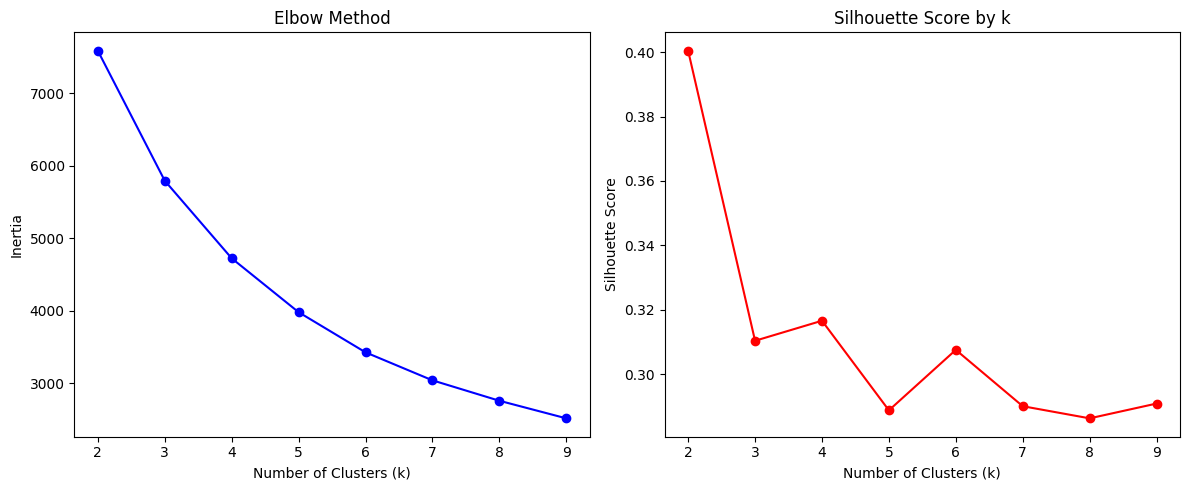

In [6]:
#Optimal K (Elbow + Silhouette)
inertia = []
silhouette = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(2,10), inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(range(2,10), silhouette, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by k')

plt.tight_layout()
plt.show()
#k = 4


In [8]:
#K-Means Clustering
best_k = 4  
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=42)
rfm["cluster"] = kmeans.fit_predict(X_scaled)

print("Clusters created successfully!")
rfm.head()


Clusters created successfully!


,customerno,recency,frequency,monetary,cluster
0,12004.0,228,1,1509.60,1
1,12006.0,219,1,24.76,1
2,12008.0,277,1,5689.57,1
3,12013.0,360,1,69.96,1
4,12024.0,177,1,149.52,1


In [17]:
#Cluster Profiling
rfm_summary = (
    rfm.groupby("cluster")[["recency","frequency","monetary"]]
       .mean()
       .round(2)
       .sort_values("monetary", ascending=False)
)
rfm_summary


,recency,frequency,monetary
cluster,,,
2,15.55,12.11,43338.15
3,97.49,3.25,11777.30
0,20.18,2.27,3674.57
1,203.20,1.23,1725.80


In [10]:
#Cluster 2 → Recency 15 days low، Frequency 12.1 high، Monetary to high (43k) vip customer

#Cluster 3 → Recency ~97 days، Frequency ~3.3، Monetary ~11.8k not bad

#Cluster 0 → Recency ~20 new، Frequency low ~2.3، Monetary ~3.7k not bad

#Cluster 1 → Recency ~203 ، Frequency low 1.23، Monetary low ~1.7k bad customers

✅ Data transformed and scaled successfully! Shape: (4718, 3)


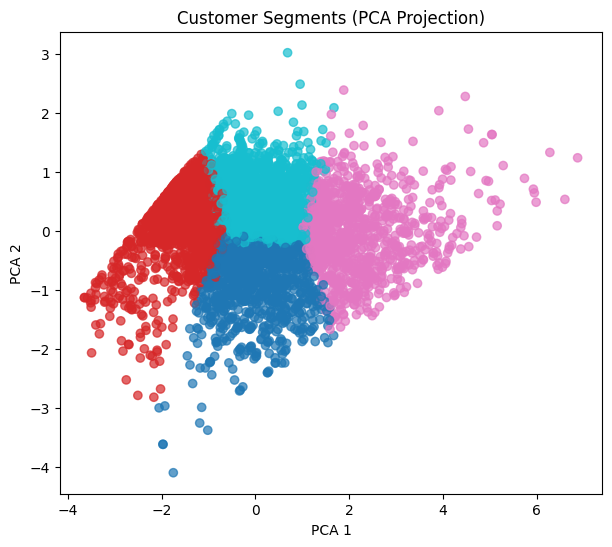

In [9]:
#Log Transform + Scaling

from sklearn.preprocessing import StandardScaler
import numpy as np

rfm_log = rfm.copy()

# Apply log(1+x) to avoid issues with zero values
rfm_log["recency_log"]   = np.log1p(rfm_log["recency"])
rfm_log["frequency_log"] = np.log1p(rfm_log["frequency"])
rfm_log["monetary_log"]  = np.log1p(rfm_log["monetary"])

# Select transformed features
X = rfm_log[["recency_log", "frequency_log", "monetary_log"]]

# Scale them
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Data transformed and scaled successfully! Shape:", X_scaled.shape)


#Visualization with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm["cluster"], cmap="tab10", alpha=0.7)
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [11]:

rfm_summary = (
    rfm.groupby("cluster")[["recency", "frequency", "monetary"]]
       .mean()
       .round(2)
       .sort_values("monetary", ascending=False)
)
rfm_summary



,recency,frequency,monetary
cluster,,,
2,15.55,12.11,43338.15
3,97.49,3.25,11777.30
0,20.18,2.27,3674.57
1,203.20,1.23,1725.80


In [12]:
rfm.to_csv("../reports/rfm_clusters.csv", index=False)
rfm_summary.to_csv("../reports/cluster_summary.csv", index=False)
print(" Saved: rfm_clusters.csv & cluster_summary.csv")


 Saved: rfm_clusters.csv & cluster_summary.csv


In [5]:
___
###Phase 2 – Customer Segmentation Modeling (K-Means + PCA Analysis)

#In this phase, the focus was on applying **K-Means clustering** to group customers based on their *Recency, Frequency,* and *Monetary (RFM)* behavior.

#Before modeling, all features were **log-transformed and scaled** to normalize the data distribution and minimize the effect of outliers. After testing several values of *k*, the optimal number of clusters was determined (using the elbow method and silhouette score).

#he results of K-Means showed **four distinct customer segments**, each representing unique behavioral and monetary patterns:
#- **Cluster 2 – VIP Loyal:** Very recent, frequent, and high-spending customers.  
#- **Cluster 3 – Active Regulars:** Regular customers with moderate spending and recency.  
#- **Cluster 0 – New/Promising:** Recently acquired customers with early but growing potential.  
#- **Cluster 1 – At-Risk/Dormant:** Inactive customers with long recency and low monetary value.  

#To better visualize these clusters, **PCA (Principal Component Analysis)** was applied to reduce the RFM features into two dimensions.  
#The PCA plot demonstrated clear group separations with minimal overlap, confirming the **robustness of the segmentation**.

#Overall, this phase successfully identified key customer groups that can guide **targeted marketing strategies** and **personalized engagement actions** in the next phase.
__

'{"dataframes": [], "user": "Mehrshad"}'